This Notebook constains code that runs statistical test to see whether the ensemble types differ after controlling for correlations.

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import StandardScaler
import openpyxl

from knobs_functions import *

In [2]:
state = 'FL' 
chamber = 'congress'
my_ensemble_list = ['distpair_ust', 'distpair', 'ust', 'pop_minus', 'base0', 'pop_plus', 'county25', 'county50', 'county75', 'county100']

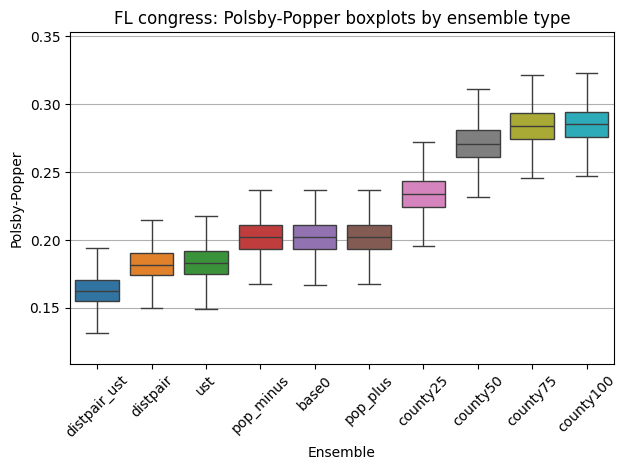

In [195]:
box_whisker_plot(state, chamber, my_ensemble_list, "Polsby-Popper")

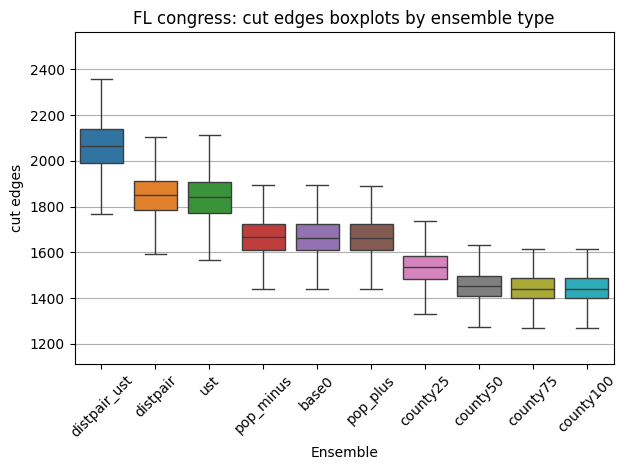

In [196]:
box_whisker_plot(state, chamber, my_ensemble_list, "cut edges")

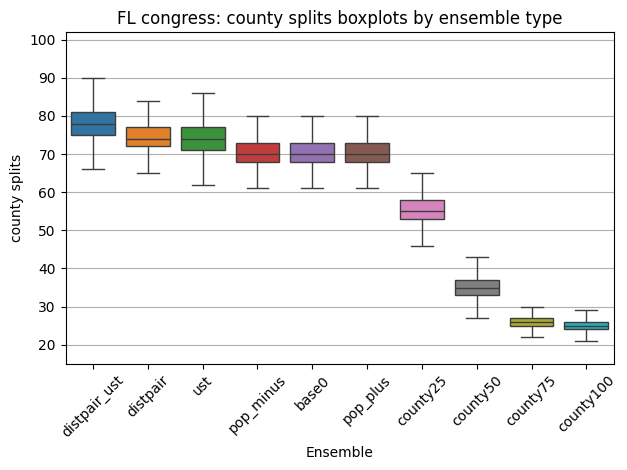

In [197]:
box_whisker_plot(state, chamber, my_ensemble_list, "county splits")

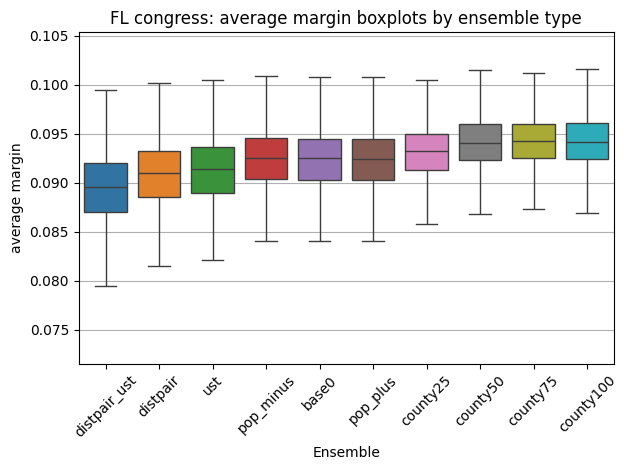

In [198]:
box_whisker_plot(state, chamber, my_ensemble_list, "average margin")

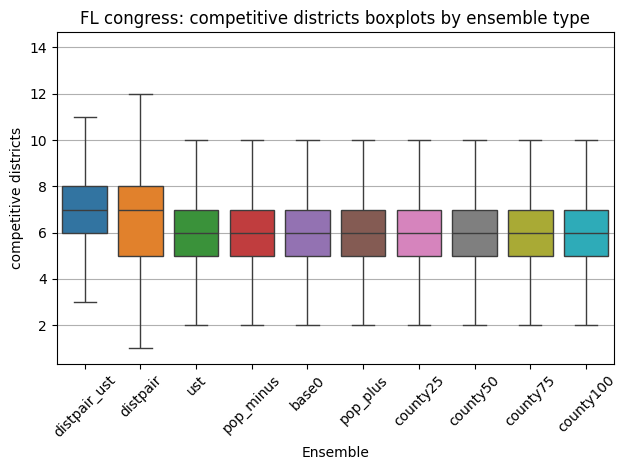

In [199]:
box_whisker_plot(state, chamber, my_ensemble_list, 'competitive districts')

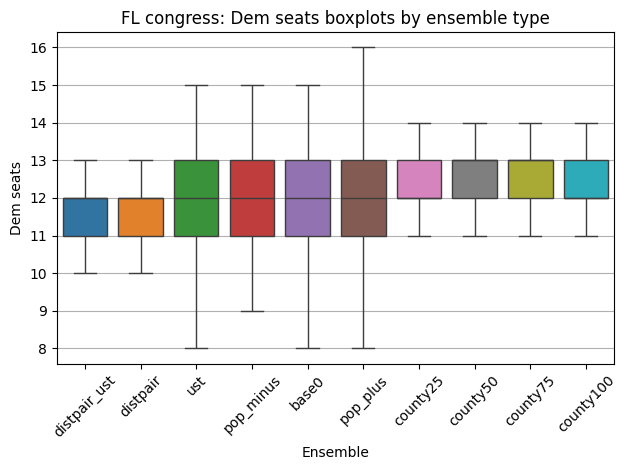

In [200]:
box_whisker_plot(state, chamber, my_ensemble_list, 'Dem seats')

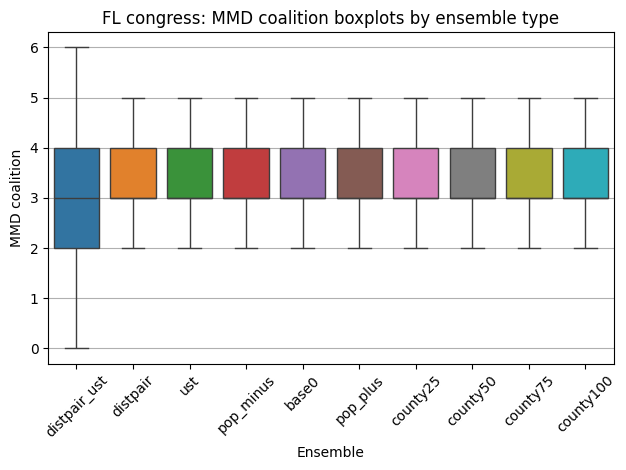

In [201]:
box_whisker_plot(state, chamber, my_ensemble_list, 'MMD coalition')

In [3]:
def correlation_table(state, chamber, my_ensemble_list=ensemble_list, my_score_list=primary_score_list, 
                      step_size=1, rounding=None, return_dataframe=False):
    '''
    Returns a correlation table for the scores in my_score_list over the ensembles in my_ensemble_list.
    Set step_size to 1 to use all the plans, or a larger number to subsample the data (to use less memory).
    Optionally returns the dataframe used to create the correlation table.
    '''
    all_rows = []

    for ensemble in my_ensemble_list:
        score_arrays = {
            score: fetch_score_array(state, chamber, ensemble, score)[::step_size]
            for score in my_score_list
        }
        num_plans = len(next(iter(score_arrays.values())))
        for i in range(num_plans):
            row = [score_arrays[score][i] for score in my_score_list] + [ensemble]
            all_rows.append(row)

    df = pd.DataFrame(all_rows, columns=my_score_list + ['ensemble'])

    corr = df.corr(numeric_only=True)
    if rounding is not None:
        corr = corr.round(rounding)

    return (corr, df) if return_dataframe else corr

In [4]:
# Let's find the correlation table for all state-chamber combinations

my_score_list = ['Reock', 'Polsby-Popper', 'cut edges', 'Dem seats', 'efficiency gap', 'mean-median', 'partisan bias', 'competitive districts', 'average margin', 'county splits', 'counties split']
D = dict() # dictionary mapping (state, chamber) to the correlation table using all ensembles    
D0 = dict() # dictionary mapping (state, chamber) to the correlation table for only the base0 ensemble

for state, chamber in state_chamber_list:
    print(state, chamber)
    D[(state, chamber)] = correlation_table(state, chamber, my_score_list=my_score_list)
    D0[(state, chamber)] = correlation_table(state, chamber, my_score_list=my_score_list, my_ensemble_list=['base0'])

FL congress
FL upper
FL lower
IL congress
IL upper
IL lower
MI congress
MI upper
MI lower
NC congress
NC upper
NC lower
NY congress
NY upper
NY lower
OH congress
OH upper
OH lower
WI congress
WI upper
WI lower


In [17]:
# Let's average the correlation tables over the state-chamber combinations

avg_corr = pd.DataFrame(0, columns = my_score_list, index = my_score_list)
avg_corr0 = pd.DataFrame(0, columns = my_score_list, index = my_score_list) # just using the base0 ensemble
for state_chamber in state_chamber_list:
    avg_corr += D[state_chamber]
    avg_corr0 += D0[state_chamber]
avg_corr /= len(state_chamber_list)
avg_corr0 /= len(state_chamber_list)
avg_corr.round(2)

,Reock,Polsby-Popper,cut edges,Dem seats,efficiency gap,mean-median,partisan bias,competitive districts,average margin,county splits,counties split
Reock,1.00,0.73,-0.73,0.01,-0.01,0.03,-0.01,-0.03,0.26,-0.63,-0.62
Polsby-Popper,0.73,1.00,-0.91,-0.00,-0.00,0.05,-0.01,-0.04,0.33,-0.95,-0.94
cut edges,-0.73,-0.91,1.00,0.00,0.00,-0.04,0.00,0.04,-0.34,0.81,0.79
Dem seats,0.01,-0.00,0.00,1.00,-0.99,-0.24,-0.62,0.01,-0.09,0.00,0.00
efficiency gap,-0.01,-0.00,0.00,-0.99,1.00,0.24,0.61,-0.02,0.11,0.01,0.01
mean-median,0.03,0.05,-0.04,-0.24,0.24,1.00,0.37,-0.18,0.21,-0.04,-0.04
partisan bias,-0.01,-0.01,0.00,-0.62,0.61,0.37,1.00,-0.03,0.14,0.02,0.02
competitive districts,-0.03,-0.04,0.04,0.01,-0.02,-0.18,-0.03,1.00,-0.52,0.04,0.04
average margin,0.26,0.33,-0.34,-0.09,0.11,0.21,0.14,-0.52,1.00,-0.32,-0.31
county splits,-0.63,-0.95,0.81,0.00,0.01,-0.04,0.02,0.04,-0.32,1.00,0.99


In [18]:
# Let's mark with * the score pairs for which the sign of the correlation is consistent across all state-chamber combinations.
avg_corr_marked = avg_corr.copy().round(2)
for score1 in my_score_list:
    for score2 in my_score_list:
        num_pos = len([1 for state_chamber in state_chamber_list if D[state_chamber].loc[score1, score2] > 0])
        consistent_sign = 1 if num_pos == len(state_chamber_list) else -1 if num_pos == 0 else 0
        if consistent_sign !=0:
            avg_corr_marked.loc[score1, score2] = f'*{avg_corr_marked.loc[score1, score2]}'
avg_corr_marked.to_excel('tables/avg_corr.xlsx')
avg_corr_marked

,Reock,Polsby-Popper,cut edges,Dem seats,efficiency gap,mean-median,partisan bias,competitive districts,average margin,county splits,counties split
Reock,*1.0,*0.73,*-0.73,0.01,-0.01,0.03,-0.01,-0.03,0.26,*-0.63,*-0.62
Polsby-Popper,*0.73,*1.0,*-0.91,-0.0,-0.0,0.05,-0.01,-0.04,*0.33,*-0.95,*-0.94
cut edges,*-0.73,*-0.91,*1.0,0.0,0.0,-0.04,0.0,0.04,*-0.34,*0.81,*0.79
Dem seats,0.01,-0.0,0.0,*1.0,*-0.99,-0.24,*-0.62,0.01,-0.09,0.0,0.0
efficiency gap,-0.01,-0.0,0.0,*-0.99,*1.0,0.24,*0.61,-0.02,0.11,0.01,0.01
mean-median,0.03,0.05,-0.04,-0.24,0.24,*1.0,0.37,-0.18,0.21,-0.04,-0.04
partisan bias,-0.01,-0.01,0.0,*-0.62,*0.61,0.37,*1.0,-0.03,0.14,0.02,0.02
competitive districts,-0.03,-0.04,0.04,0.01,-0.02,-0.18,-0.03,*1.0,*-0.52,0.04,0.04
average margin,0.26,*0.33,*-0.34,-0.09,0.11,0.21,0.14,*-0.52,*1.0,*-0.32,*-0.31
county splits,*-0.63,*-0.95,*0.81,0.0,0.01,-0.04,0.02,0.04,*-0.32,*1.0,*0.99


In [14]:
# Let's make a table showing the range of values over the state-chamber combinations
range_corr = pd.DataFrame(0, columns = my_score_list, index = my_score_list)
for score1 in my_score_list:
    for score2 in my_score_list:
        min_corr = min([D[state_chamber].loc[score1, score2] for state_chamber in state_chamber_list])
        max_corr = max([D[state_chamber].loc[score1, score2] for state_chamber in state_chamber_list])
        range_corr.loc[score1, score2] = f'({min_corr:.2f},{max_corr:.2f})'
range_corr.to_excel('tables/range_corr.xlsx')

In [216]:
small_score_list = ['Polsby-Popper', 'average margin','county splits']
corr, df = correlation_table('FL', 'congress', my_ensemble_list=my_ensemble_list, my_score_list=small_score_list, step_size=1, return_dataframe=True)

KeyboardInterrupt: 

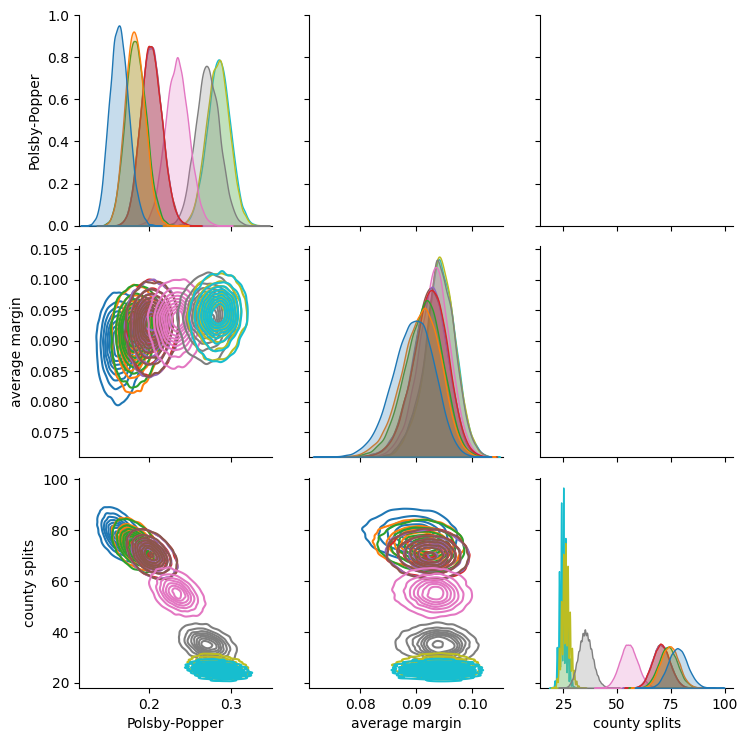

In [184]:
sns.pairplot(df, hue='ensemble', kind = 'kde')

In [217]:
# Now let's run ANCOVA

# first convert all measurements to standard units, so that the regression coefficients are comparable
df_std = df.copy()
scaler = StandardScaler()
df_std[["average margin", "Polsby-Popper", "county splits"]] = scaler.fit_transform(
    df[["average margin", "Polsby-Popper", "county splits"]]
)

# Now find the regression coefficients
model_std = ols('Q("average margin") ~ Q("Polsby-Popper") + Q("county splits") + C(ensemble)', data=df_std).fit()
print(model_std.summary())

                             OLS Regression Results                            
Dep. Variable:     Q("average margin")   R-squared:                       0.192
Model:                             OLS   Adj. R-squared:                  0.192
Method:                  Least Squares   F-statistic:                     4326.
Date:                 Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                         19:29:12   Log-Likelihood:            -2.6244e+05
No. Observations:               200000   AIC:                         5.249e+05
Df Residuals:                   199988   BIC:                         5.250e+05
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercep

In [218]:
ancova_table = anova_lm(model_std, typ=2)
print(ancova_table)

                           sum_sq        df           F         PR(>F)
C(ensemble)           5894.710767       9.0  810.759575   0.000000e+00
Q("Polsby-Popper")     128.433261       1.0  158.982604   1.949074e-36
Q("county splits")     773.015896       1.0  956.886703  1.325266e-209
Residual            161559.255088  199988.0         NaN            NaN


In [211]:
ancova_table['sum_sq'] 

C(ensemble)             5894.710767
Q("Polsby-Popper")       128.433261
Q("county splits")       773.015896
Residual              161559.255088
Name: sum_sq, dtype: float64

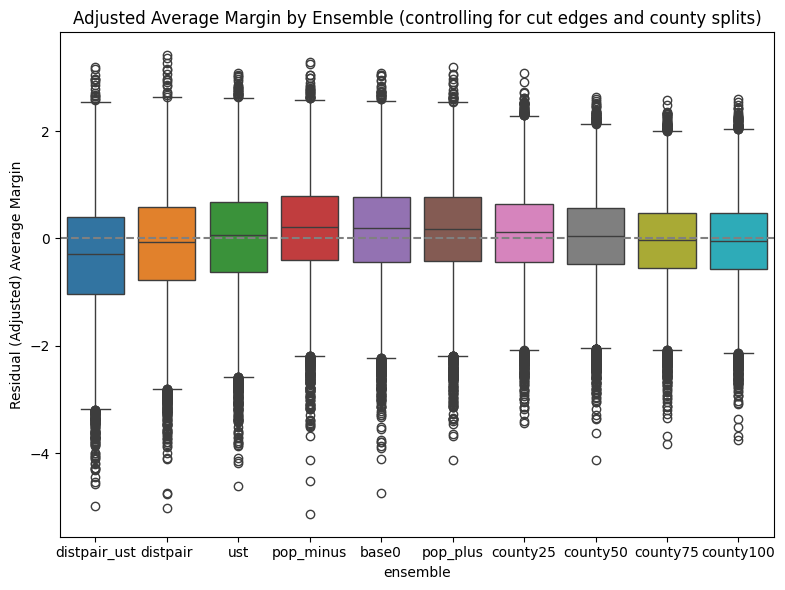

In [209]:
# Create a new DataFrame with residuals

# Regress average margin on cut edges
model_margin = ols('Q("average margin") ~ Q("Polsby-Popper") + Q("county splits")', data=df_std).fit()

# Get residuals (variation in average margin not explained by cut edges)
df_std["adjusted_margin"] = model_margin.resid

# Plot the adjusted average margins by ensemble
plt.figure(figsize=(8, 6))
sns.boxplot(x="ensemble", y="adjusted_margin", data=df_std, hue="ensemble")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Adjusted Average Margin by Ensemble (controlling for cut edges and county splits)")
plt.ylabel("Residual (Adjusted) Average Margin")
plt.tight_layout()
plt.show()